In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import umap.umap_ as umap
from tqdm import tqdm
from math import ceil
import seaborn as sns
import copy
import random
import math
from collections import Counter
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
K = 15
MALIGNANT_PER_PSEUDOPATIENT=35

In [3]:
memberships = pd.read_csv("../../data/GBM_Neftel/CanSig_MetaMembership.csv", index_col=0)
memberships = memberships[memberships["metamembership"] != "-2.0"]
memberships.index = ["-".join(x.split("-")[:-1]) for x in memberships.index.tolist()]

In [4]:
metadata = pd.read_csv("../../data/GBM_Neftel/Metadata.txt", skiprows=[1], index_col=0, delimiter="\t")

In [5]:
dataset = pd.read_csv("../../data/GBM_Neftel/IDHwtGBM.processed.SS2.logTPM.txt", index_col=0, delimiter="\t")

In [6]:
change_scale = np.vectorize(lambda y: np.power(2,y)-1)

In [7]:
markers_ct = pd.DataFrame()
malignant_states = [f"metasig{i}" for i in range(1,6)]
tme_states = ["Macrophage", "Oligodendrocyte", "T-cell"]
# malignant states
for ct in malignant_states:
    markers_ct[ct] = pd.Index(pd.read_csv(f"../../data/GBM_Neftel/signatures/{ct}.csv", index_col=0)["0"]).intersection(dataset.index).difference(pd.Index(markers_ct.values.flatten()))[:50]
for ct in tme_states:
    markers_ct[ct] = pd.read_csv(f"../../data/GBM_Neftel/signatures/{ct}.csv", index_col=0).index.intersection(dataset.index).difference(pd.Index(markers_ct.values.flatten()))[:50]
markers_all = pd.Index(markers_ct.T.to_numpy().flatten())

In [8]:
markers_ct.T.to_csv("markers.csv", header=False)

In [9]:
def get_purity(data, mapping):
    cnt_malignant, cnt_tme = 0, 0
    for k in mapping:
        if k in malignant_states:
            cnt_malignant += mapping[k].size
        else:
            assert k in tme_states
            cnt_tme += mapping[k].size
    return 1.0 * cnt_malignant / (cnt_malignant + cnt_tme), cnt_malignant, cnt_tme

In [10]:
def get_cells(mapping, cell_types):
    cells = None
    found = False
    for k in mapping:
        if k in cell_types:
            if not found:
                found = True
                cells = mapping[k]
            else:
                cells = cells.union(mapping[k])
    return cells

In [11]:
def get_gexp_prop(pseudopatient, mapping):
    new_mapping = copy.deepcopy(mapping)
    for cell_type in mapping:
        # new mapping because we resampled cells
        new_mapping[cell_type] = new_mapping[cell_type].intersection(pseudopatient.columns)
    
    gexp_ = pseudopatient.agg(np.mean, axis=1)
    true_prop_ = pd.Series(name="true_proportions", dtype='float64')
    for cell_type in new_mapping:
        true_prop_[cell_type] = get_cells(new_mapping, [cell_type]).size
    true_prop_ = true_prop_.div(true_prop_.sum())
    return gexp_, true_prop_
    

"""def sample(data, mapping, P, alpha=0.5):
    data_purity, M, T = get_purity(data, mapping)
    if data_purity > P:
        # remove malignant cells
        #print("removing malignant cells")
        if data_purity == 1: assert False, "only malignant cells available so cant reduce purity"
        M = P*T/(1-P)
    elif data_purity < P:
        #print("removing tme cells")
        T = (M-P*M)/P
    else:
        #print("purity just right")
        pass
    
    malignant_cells = get_cells(mapping, malignant_states)
    tme_cells = get_cells(mapping, tme_states)
    
    M = ceil(alpha*M)
    T = ceil(alpha*T)
    
    #print(f"{data_purity=} {M=} {T=}")
    
    # sample alpha * M malignant cells
    # alpha * T true cells
    if data_purity == 1:
        sampled = data[malignant_cells].sample(n=M, axis=1)
    else:
        sampled = pd.concat(
            [data[malignant_cells].sample(n=M, axis=1),
            data[tme_cells].sample(n=T, axis=1)],
            axis=1
        )
    
    return sampled
"""

In [12]:
# TODO better sampling
def sample_cells(cells, mapping, counts):
    if len(cells)==0: return [[] for count in counts]
    batches = math.ceil(sum(counts)/len(cells))
    sampled = cells.copy()
    sampled *= batches
    random.shuffle(sampled)
    #print("sampled",sampled,"at ratio",sum(counts)/len(cells))

    i = 0
    arr = []
    for count in counts:
        arr.append(sampled[i:i+count])
        i += count
    return arr
    return [random.sample(cells, count) for count in counts]

In [13]:
def lo_tme_ct(prop):
    cts = pd.Index(tme_states).intersection(prop.index)
    if len(cts) == 1:
        # only one tme type -> cant leave anything out
        return False
        
    # count celltypes that have value 0 in prop -> tme type present but not sampled
    # print(prop[cts], (prop[cts]==0).any())
    return (prop[cts]==0).sum() >= 1

In [14]:
def frac_to_cnt(cell_cnt, fracs):
    cells_per_partition = fracs.apply(lambda frac: math.floor(cell_cnt*frac))
    diff_per_partition = fracs.apply(lambda frac: cell_cnt*frac-math.floor(cell_cnt*frac))
    remaining_cells = cell_cnt - sum(cells_per_partition)
    diff_per_partition = diff_per_partition.sort_values(ascending=False)
    for i in range(remaining_cells):
        partition_index = diff_per_partition.index[i]
        cells_per_partition[partition_index] += 1
    return cells_per_partition

In [15]:
tuples = [(patient, str(i)) for patient in metadata["Sample"].unique() for i in range(K)]
index = pd.MultiIndex.from_tuples(tuples, names=["patient", "pseudopatient"])
gexp = pd.DataFrame(index=index, columns=markers_all)
true_prop = pd.DataFrame(index=index, columns=(malignant_states+tme_states))
gexp_orig = pd.DataFrame(index=metadata["Sample"].unique(), columns=markers_all)
true_prop_orig = pd.DataFrame(index=metadata["Sample"].unique(), columns=(malignant_states+tme_states))

cell_counts = pd.DataFrame(index=metadata["Sample"].unique(), columns=(malignant_states+tme_states))

cnt_lo_tme = Counter() # % of times we left out >= 1 tme celltype when sampling
patient_sizes = []

for sample_name, metadata_sample in metadata.groupby("Sample"):
    i = 0
    barcodes = metadata_sample.index
    dataset_sample = dataset[barcodes]
    dataset_sample = dataset_sample.loc[markers_all]
    dataset_sample = dataset_sample.apply(change_scale)

    cell_mapping = {}
    malignant_cells = []
    tme_cells = []
    malignant_cts = 0

    for cell_type, metadata_cell_type in metadata_sample.groupby("CellAssignment"):
        cell_index = metadata_cell_type.index
        if cell_type == "Malignant":
            # only take those malignant cells malignant state is known
            cell_index = cell_index.intersection(memberships.index)
            for malignant_state, malignant_state__cells in memberships.loc[cell_index].groupby("metamembership"):
                malignant_cts += 1
                cell_mapping[malignant_state] = malignant_state__cells.index
                malignant_cells += malignant_state__cells.index.tolist()
        else:
            cell_mapping[cell_type] = cell_index
            tme_cells += cell_index.tolist()

    # prefiltering
    prefiltered_cells = get_cells(cell_mapping, malignant_states + tme_states)
    dataset_sample = dataset_sample[prefiltered_cells]
    purity, M, T = get_purity(dataset_sample, cell_mapping)  
    print(f"sample {sample_name}: it has purity {purity*100}% and {M=}, {T=}")
    if purity < .1:
        print(f"sample {sample_name} discarded")
        continue
    patient_sizes.append(len(prefiltered_cells))        

    # original patient    
    true_prop_ = pd.Series(name="true_proportions", dtype='float64')
    for cell_type in cell_mapping:
        true_prop_[cell_type] = get_cells(cell_mapping, [cell_type]).size
    true_prop_ = true_prop_.div(true_prop_.sum())
    gexp_orig.loc[sample_name] = dataset_sample.agg(np.mean, axis=1)
    true_prop_orig.loc[sample_name] = true_prop_


    # for analyzing co-occurence of malignant states
    cell_counts.loc[sample_name] = pd.Series({ct:len(cell_mapping[ct]) for ct in cell_mapping})

    # pseudopatients
    cnt_pseudopatients = round(len(malignant_cells)/MALIGNANT_PER_PSEUDOPATIENT)
    metasignature_proba = pd.DataFrame()
    metasignature_cnts = pd.DataFrame()

    malignant_partitions = [[] for _ in range(cnt_pseudopatients)]
    for ct in cell_mapping:
        if ct.startswith("metasig"):
            metasignature_proba[ct] = np.random.dirichlet(np.ones_like(np.arange(cnt_pseudopatients)))
            metasignature_cnts[ct] = frac_to_cnt(len(cell_mapping[ct]), metasignature_proba[ct])
            #print(ct,len(cell_mapping[ct]))
            cells_todraw = cell_mapping[ct].tolist()
            random.shuffle(cells_todraw)

            for j in range(cnt_pseudopatients):
                # draw metasignature_cnts.loc[j,ct] many cells of ct for pseudopatient j
                N = metasignature_cnts.loc[j,ct]
                #print(f"{N} cells of {ct} for pseudopatient {j}")
                malignant_partitions[j] += cells_todraw[:N]
                cells_todraw = cells_todraw[N:]
            assert cells_todraw == []

    #display(metasignature_proba)
    #display(metasignature_cnts)

    M_ = len(malignant_partitions[0])
    min_purity = max(M_ / (M_ + T), 0.4)
    max_purity = max(0.99, min_purity)
    # choose purities
    sample_purities = np.linspace(min_purity, max_purity, len(malignant_partitions))

    tme_cnts = []
    for desired_purity in sample_purities:
        #desired_purity = random.uniform(min_purity, max_purity)
        T_ = M_*(1-desired_purity)/desired_purity
        #print(f"split has purity {min_purity} if taking all tme cells, we desire purity {desired_purity}, we need {T_} TME cells")
        tme_cnts.append(round(T_))

    # sample TME cells
    sampled_tme = sample_cells(tme_cells, cell_mapping, tme_cnts)

    # build the pseudopatients
    for malignant_split, tme_partition in zip(malignant_partitions, sampled_tme):
        dataset_pseudopatient = dataset_sample[list(malignant_split) + tme_partition]
        #print(malignant_split)
        x = {}
        for cl in malignant_split:
            for ct in cell_mapping:
                if cl in cell_mapping[ct]:
                    try:
                        x[ct] += 1
                    except:
                        x[ct] = 1

        #display(dataset_pseudopatient)
        gexp_, true_prop_ = get_gexp_prop(dataset_pseudopatient, cell_mapping)
        gexp.loc[(sample_name, str(i))] = gexp_
        true_prop.loc[(sample_name, str(i))] = true_prop_
        cnt_lo_tme[lo_tme_ct(true_prop_)] += 1
        i += 1 

sample BT1160: it has purity 100.0% and M=141, T=0
sample BT1187: it has purity 0.0% and M=0, T=211
sample BT1187 discarded
sample BT749: it has purity 98.48484848484848% and M=130, T=2
sample BT771: it has purity 85.52631578947368% and M=65, T=11
sample BT786: it has purity 95.77464788732394% and M=68, T=3
sample BT830: it has purity 100.0% and M=86, T=0
sample BT85: it has purity 98.83720930232558% and M=85, T=1
sample BT920: it has purity 92.44186046511628% and M=159, T=13
sample MGH100: it has purity 100.0% and M=143, T=0
sample MGH101: it has purity 63.84615384615384% and M=83, T=47
sample MGH102: it has purity 57.08502024291497% and M=141, T=106
sample MGH104: it has purity 100.0% and M=191, T=0
sample MGH105: it has purity 51.42857142857142% and M=252, T=238
sample MGH106: it has purity 57.333333333333336% and M=86, T=64
sample MGH110: it has purity 69.47368421052632% and M=132, T=58
sample MGH113: it has purity 67.37588652482269% and M=95, T=46
sample MGH115: it has purity 95.2

In [16]:
cnt_lo_tme

Counter({False: 79, True: 21})

In [17]:
true_prop = true_prop.dropna(axis=0, how="all")
gexp = gexp.dropna(axis=0, how="all")
true_prop = true_prop.fillna(0.0)
gexp = gexp.fillna(0.0)

true_prop_orig = true_prop_orig.dropna(axis=0, how="all")
gexp_orig = gexp_orig.dropna(axis=0, how="all")
true_prop_orig = true_prop_orig.fillna(0.0)
gexp_orig = gexp_orig.fillna(0.0)

cell_counts = cell_counts.fillna(0.0)

<AxesSubplot: >

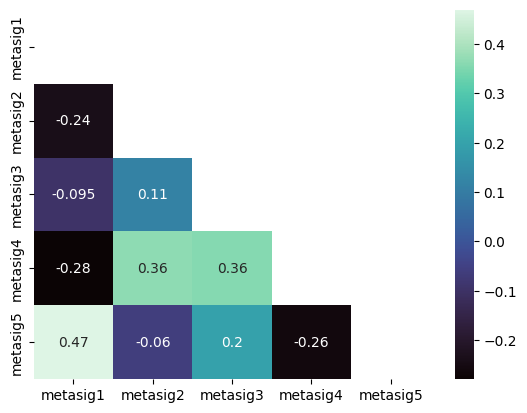

In [18]:
# correlation of occurance of states
corr = cell_counts[malignant_states].corr()
corr_tril = corr.where(np.tril(np.ones(corr.shape)).astype(bool))
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr_tril, mask=mask, annot=True, cmap="mako")

In [19]:
true_prop.to_csv("gbm_neftel_true_prop.csv")
gexp.to_csv("gbm_neftel_gexp.csv")
gexp_orig.to_csv("gbm_neftel_gexp_orig.csv")
true_prop_orig.to_csv("gbm_neftel_true_prop_orig.csv")

In [20]:
true_prop["purity"] = true_prop[malignant_states].sum(axis=1)
true_prop_orig["purity"] = true_prop_orig[malignant_states].sum(axis=1)
true_prop_orig["number of cells"] = patient_sizes

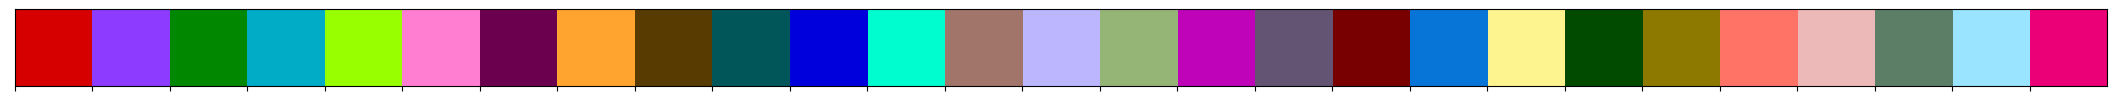

In [21]:
import colorcet as cc
palette = sns.color_palette(cc.glasbey, n_colors=27)
sns.palplot(sns.color_palette(cc.glasbey, n_colors=27))

In [22]:
pca = PCA(n_components=2)
pca.fit(gexp.apply(lambda x: np.log2(x+1)))

PCA(n_components=2)

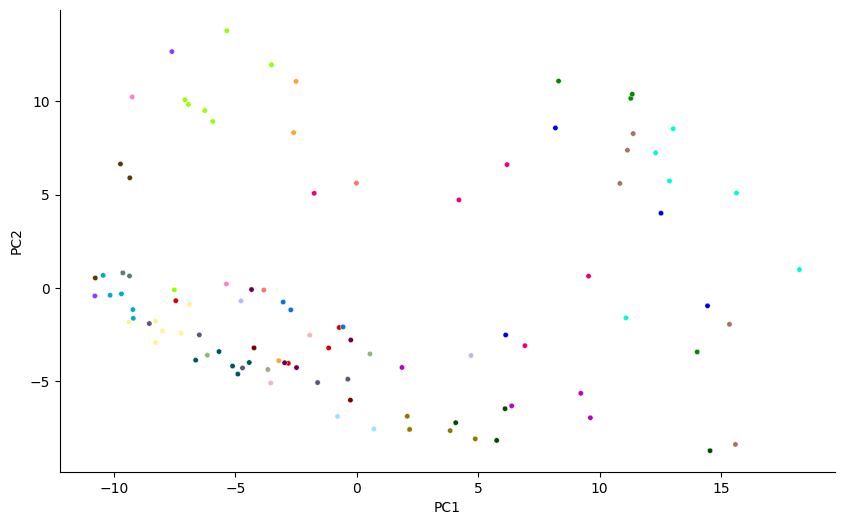

In [23]:
z = pca.transform(gexp.apply(lambda x: np.log2(x+1)))
pc1, pc2 = zip(*z)
plt.figure(figsize=(10,6))
sns.scatterplot(x=pc1,y=pc2,hue=[a for (a,b) in gexp.index],legend=False,s=15, palette=palette)
xlim = plt.xlim()
ylim = plt.ylim()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.title("Pseudopatient PCA stratified by original patient")

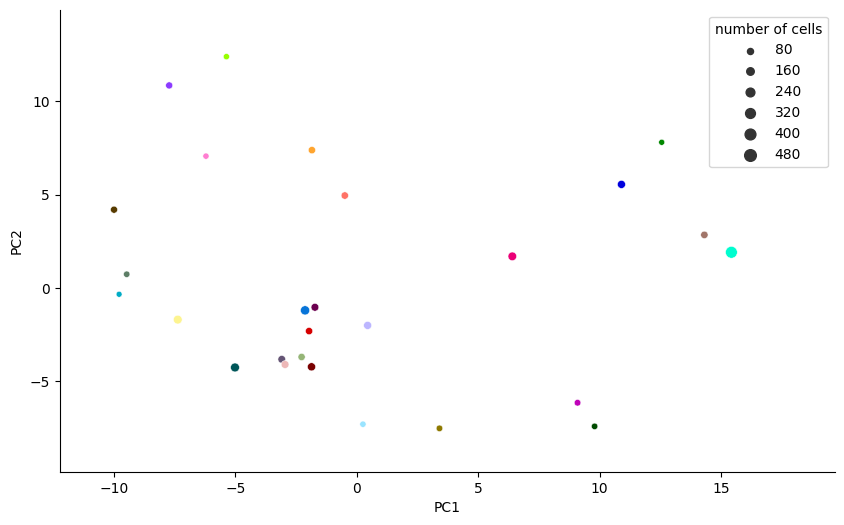

In [24]:
z = pca.transform(gexp_orig.apply(lambda x: np.log2(x+1)))
pc1, pc2 = zip(*z)
plt.figure(figsize=(10,6))
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
scatter = sns.scatterplot(x=pc1,y=pc2,hue=gexp_orig.index.tolist(), size=patient_sizes, palette=palette)
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles[27:], labels[27:], title='number of cells')
#plt.title("PCA of original patients")

Text(0.5, 1.0, 'PCA of original patients')

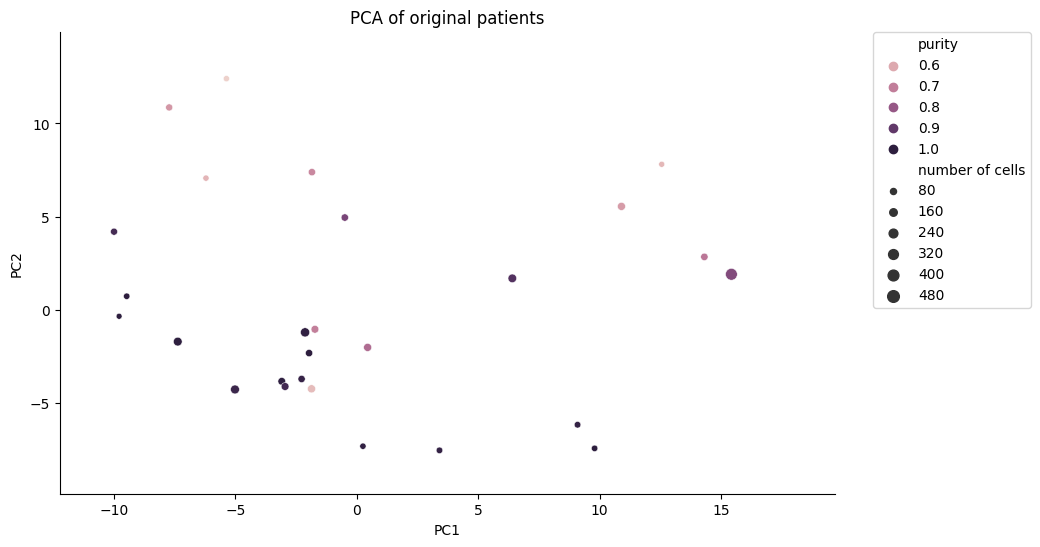

In [25]:
z = pca.transform(gexp_orig.apply(lambda x: np.log2(x+1)))
pc1, pc2 = zip(*z)
plt.figure(figsize=(10,6))
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
sns.scatterplot(x=pc1,y=pc2, hue=true_prop_orig["purity"], size=true_prop_orig["number of cells"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title("PCA of original patients")

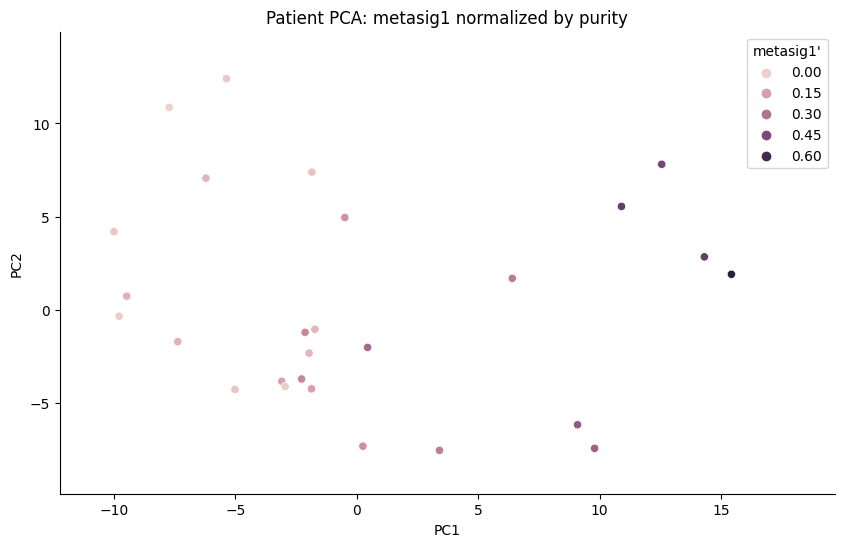

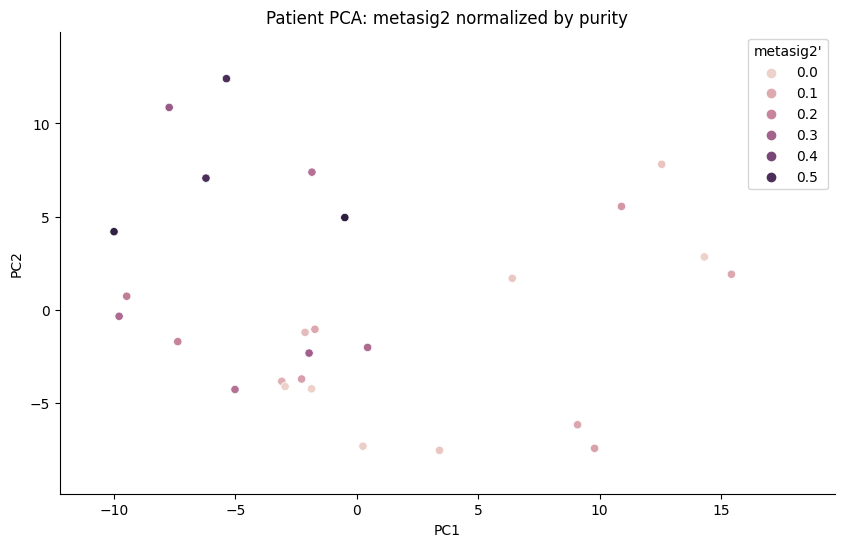

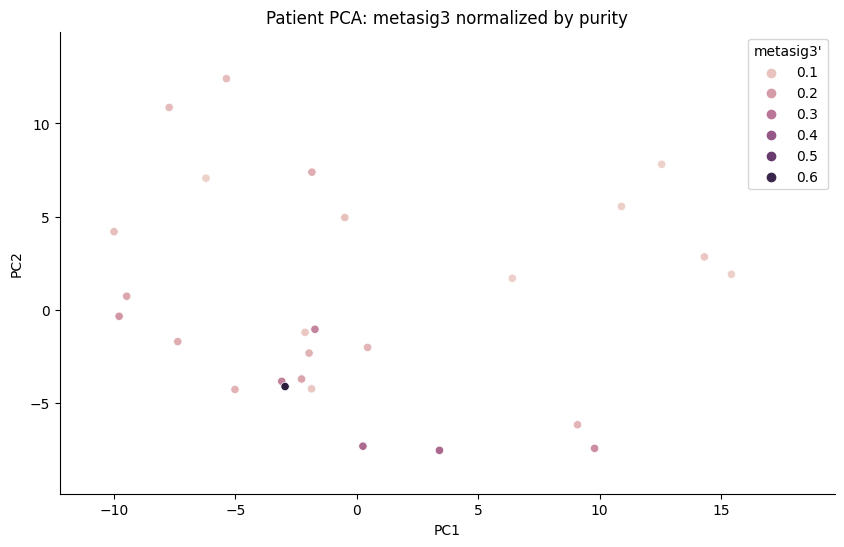

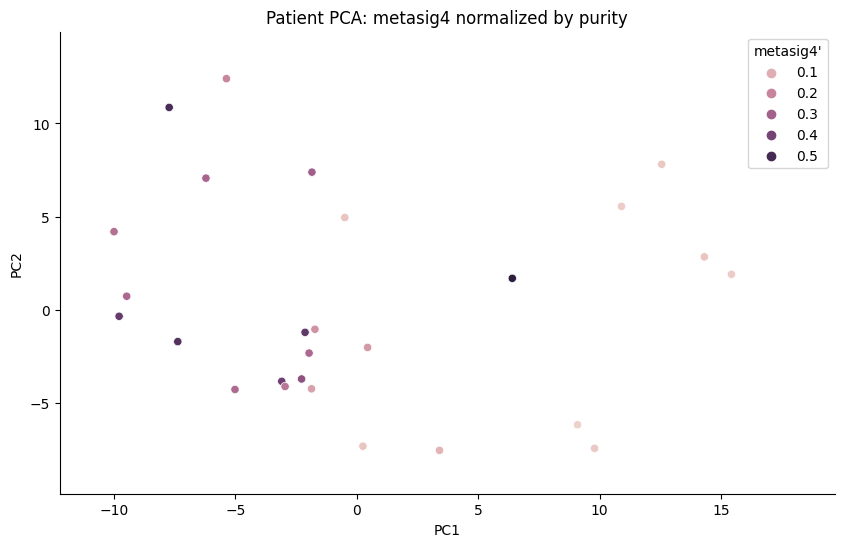

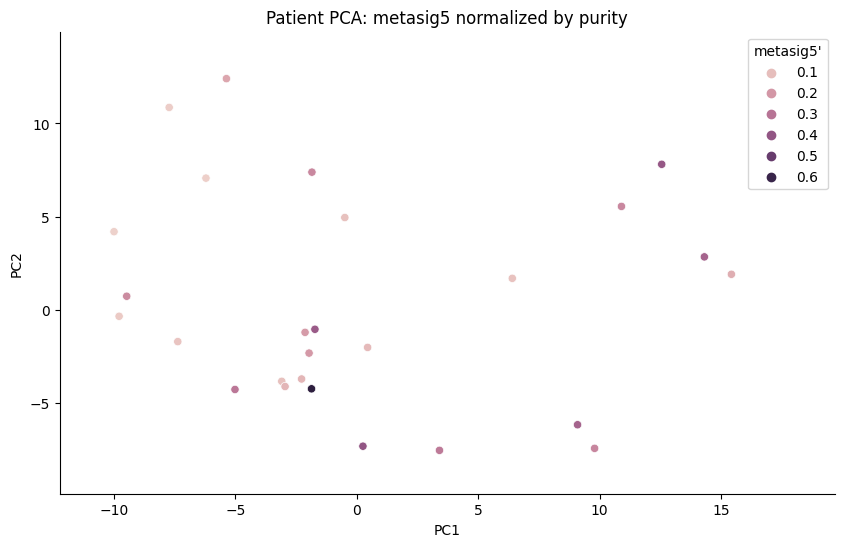

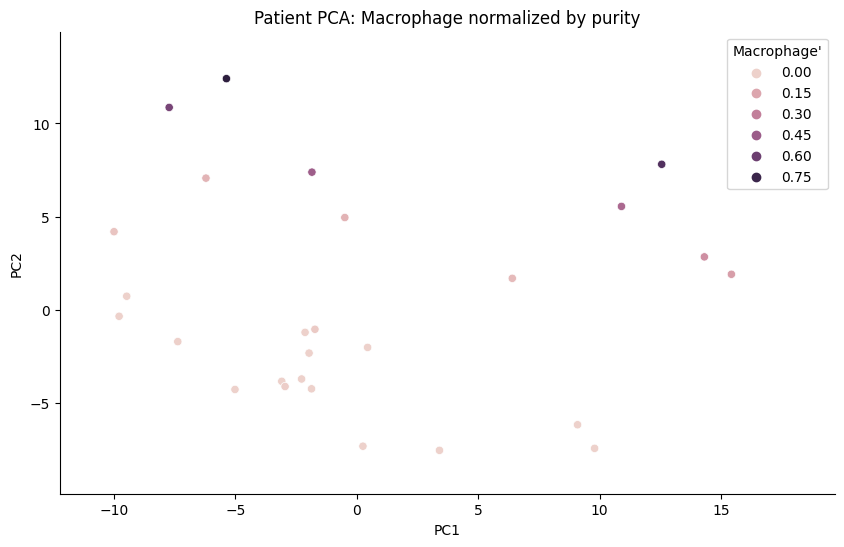

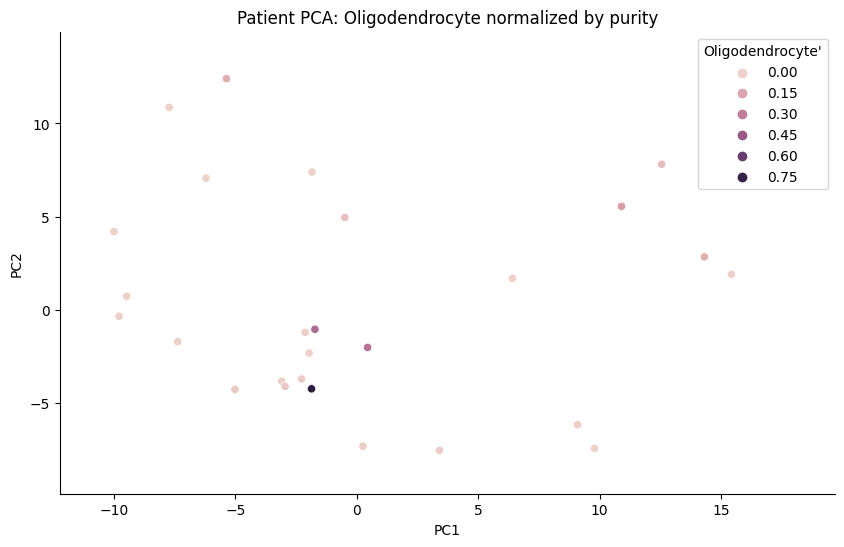

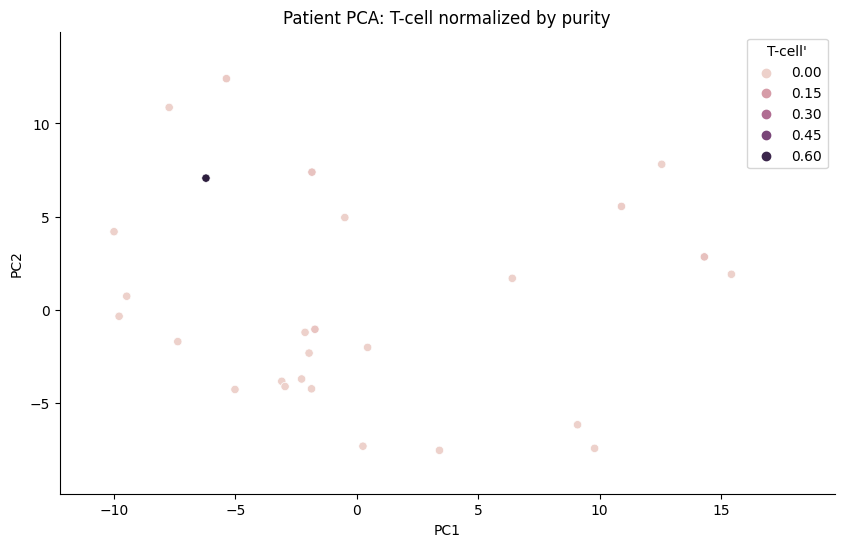

In [26]:
z = pca.transform(gexp_orig.apply(lambda x: np.log2(x+1)))
pc1, pc2 = zip(*z)
for ct in malignant_states+tme_states:
    plt.figure(figsize=(10,6))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    true_prop_orig[f"{ct}'"] = true_prop_orig[ct]/true_prop_orig["purity"]
    sns.scatterplot(x=pc1,y=pc2,hue=true_prop_orig[f"{ct}'"])
    plt.title(f"Patient PCA: {ct} normalized by purity")
    plt.show()

Text(0.5, 1.0, 'Pseudopatient PCA in training set')

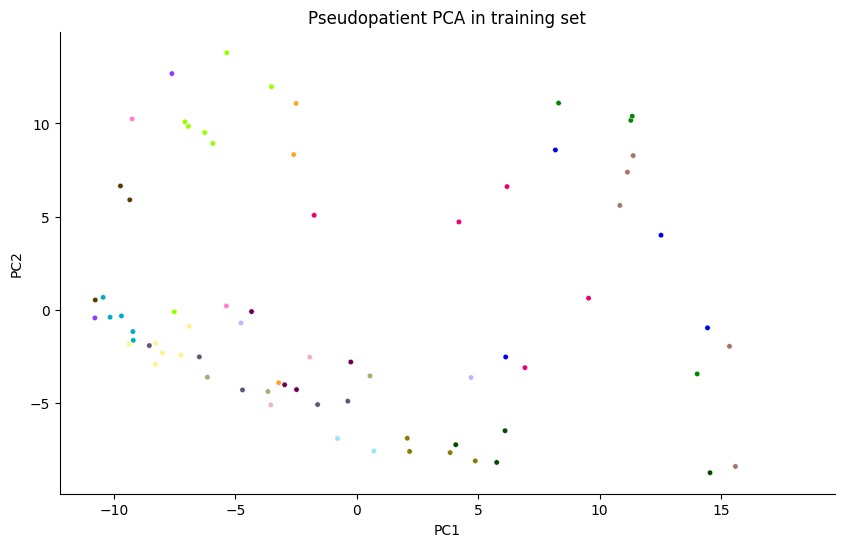

In [27]:
train_patients = ['MGH128', 'BT1160', 'BT85', 'MGH122', 'MGH143', 'MGH115', 'MGH129', 'MGH104', 'MGH106', 'BT749', 'MGH113', 'BT786', 'MGH66', 'MGH125', 'MGH101', 'MGH105', 'MGH110', 'MGH102', 'BT920']
z = pca.transform(gexp.loc[train_patients].apply(lambda x: np.log2(x+1)))
pc1, pc2 = zip(*z)
plt.figure(figsize=(10,6))
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
sns.scatterplot(x=pc1,y=pc2,hue=[a for (a,b) in gexp.loc[train_patients].index], hue_order=gexp_orig.index, legend=False, palette=palette,s=15)
plt.title("Pseudopatient PCA in training set")

Text(0.5, 1.0, 'Pseudopatient PCA in test set')

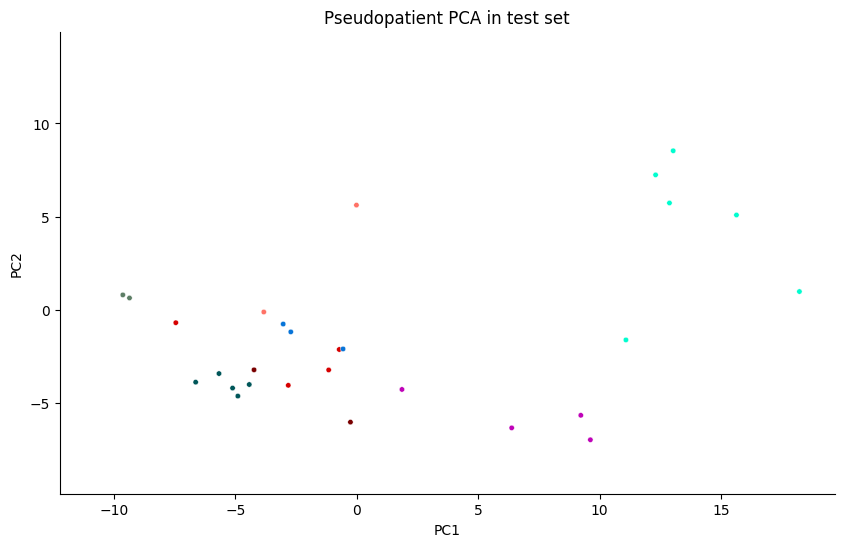

In [28]:
test_patients = ['BT771', 'MGH151', 'MGH100', 'MGH136', 'MGH152', 'MGH121', 'MGH124', 'BT830']
z = pca.transform(gexp.loc[test_patients].apply(lambda x: np.log2(x+1)))
pc1, pc2 = zip(*z)
plt.figure(figsize=(10,6))
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
sns.scatterplot(x=pc1,y=pc2,hue=[a for (a,b) in gexp.loc[test_patients].index],  hue_order=gexp_orig.index, palette=palette,legend=False, s = 15)
plt.title("Pseudopatient PCA in test set")

Text(0.5, 1.0, 'Pseudopatient PCA: purity')

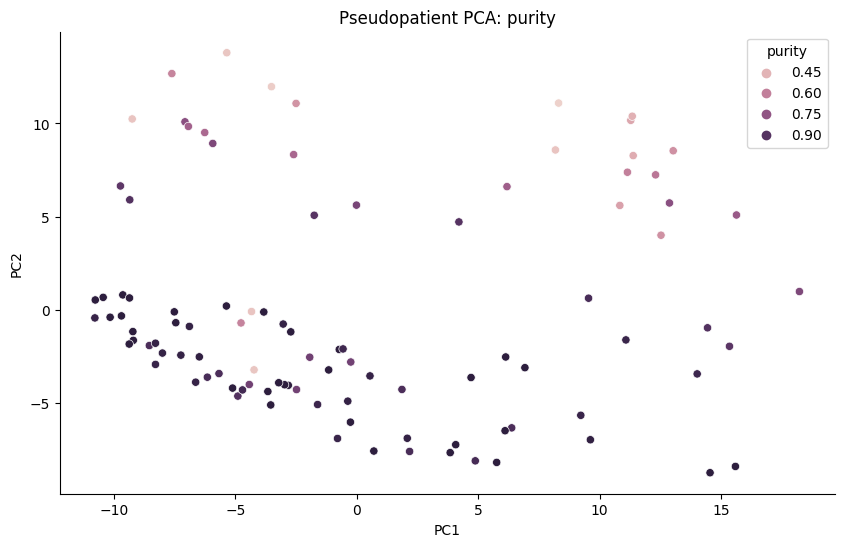

In [29]:
z = pca.transform(gexp.apply(lambda x: np.log2(x+1)))
pc1, pc2 = zip(*z)
plt.figure(figsize=(10,6))
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
sns.scatterplot(x=pc1,y=pc2,hue=true_prop["purity"])
plt.title("Pseudopatient PCA: purity")

/var/folders/7s/vtf98djj2gg457zg0jt_297r0000gn/T/ipykernel_2586/879677927.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,6))


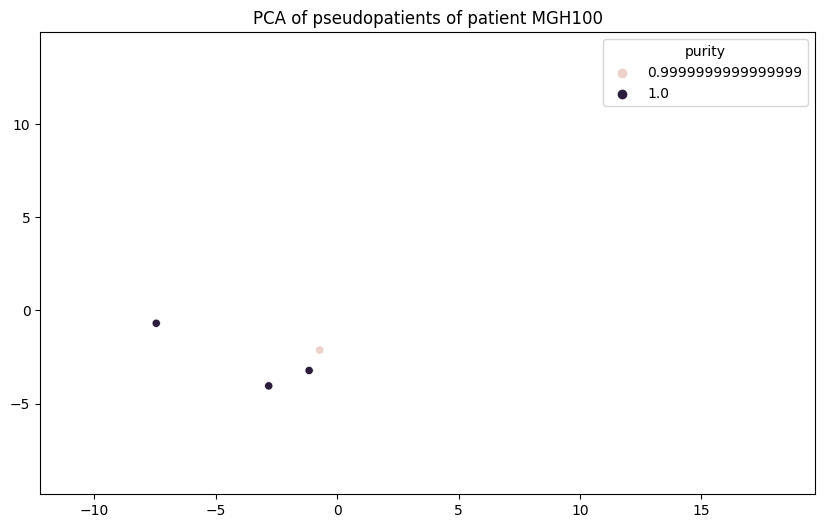

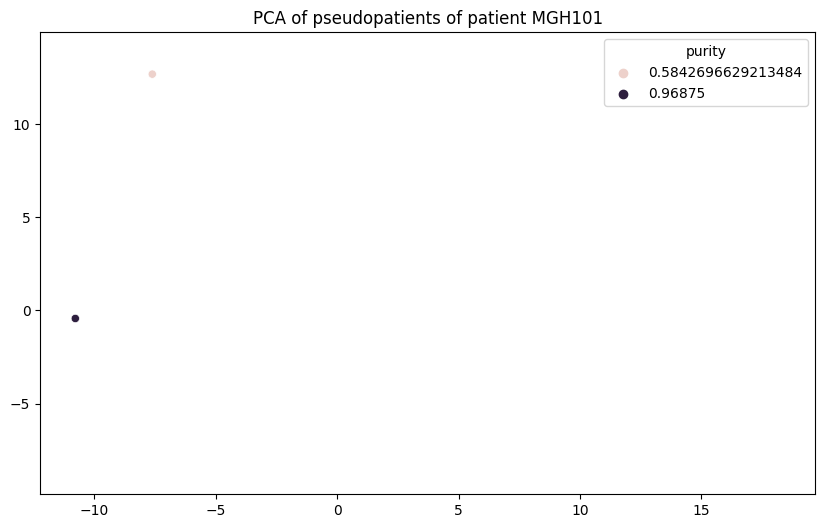

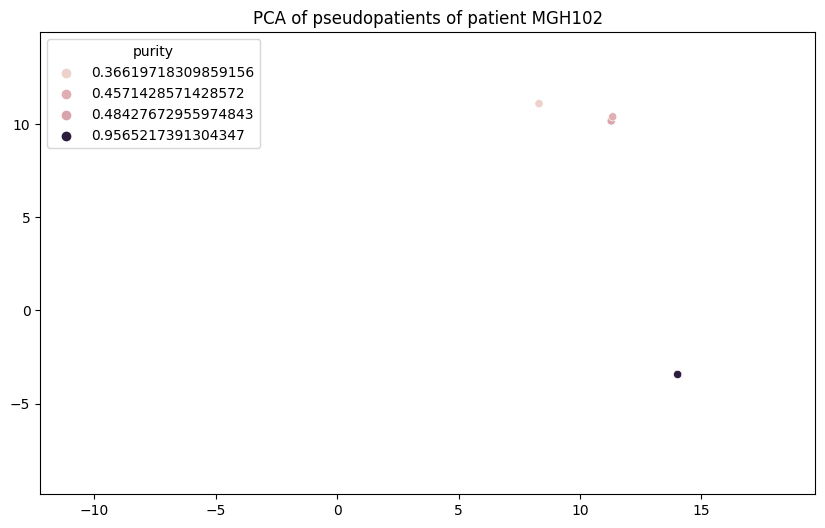

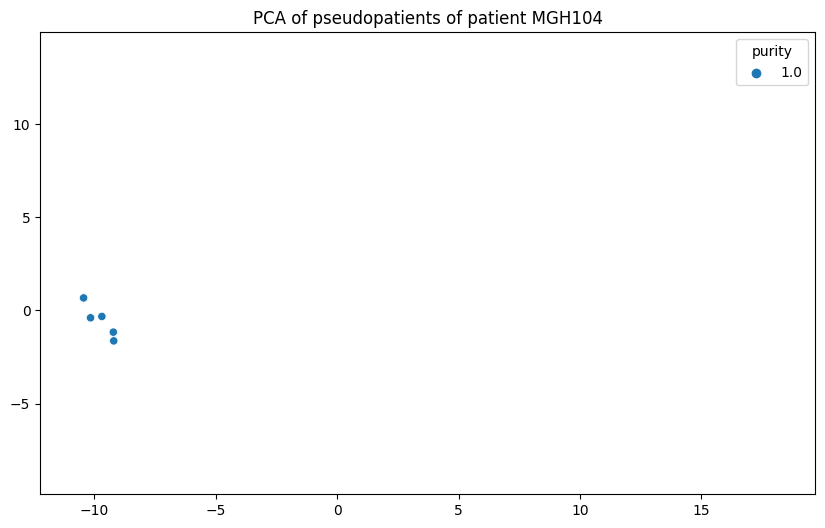

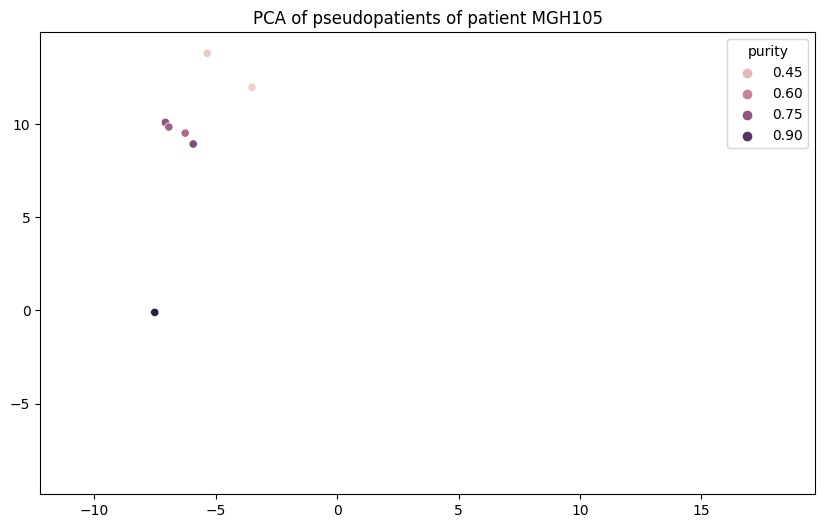

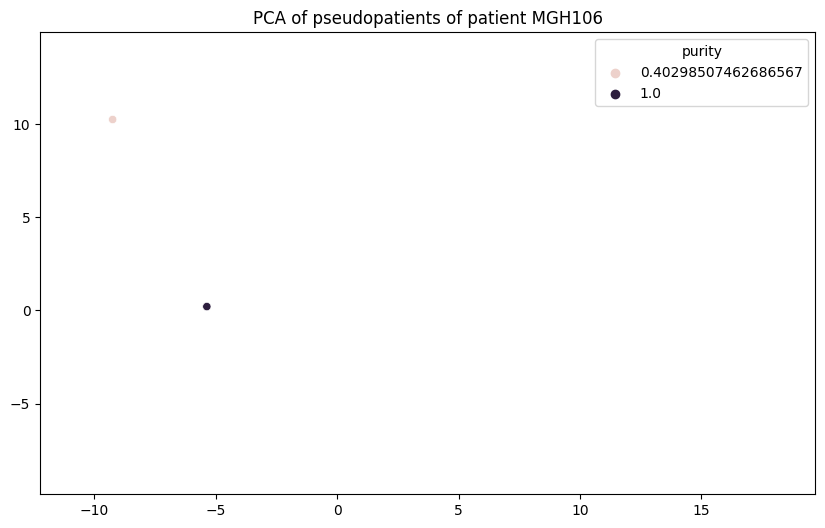

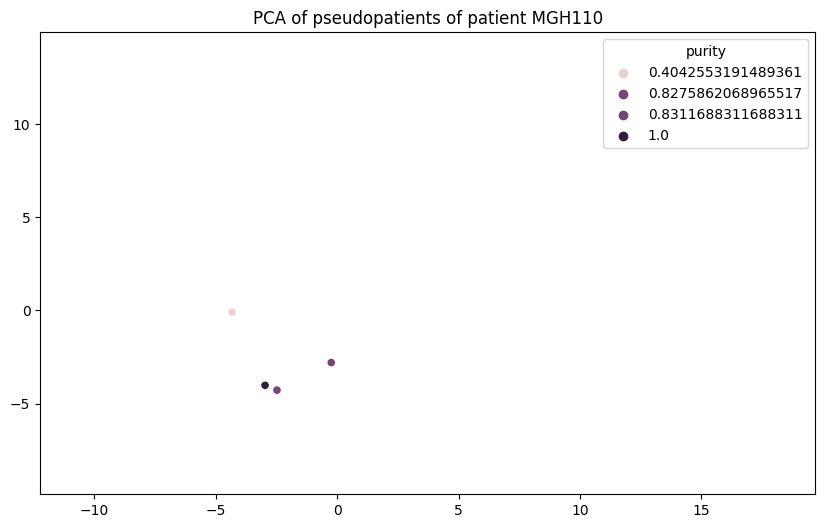

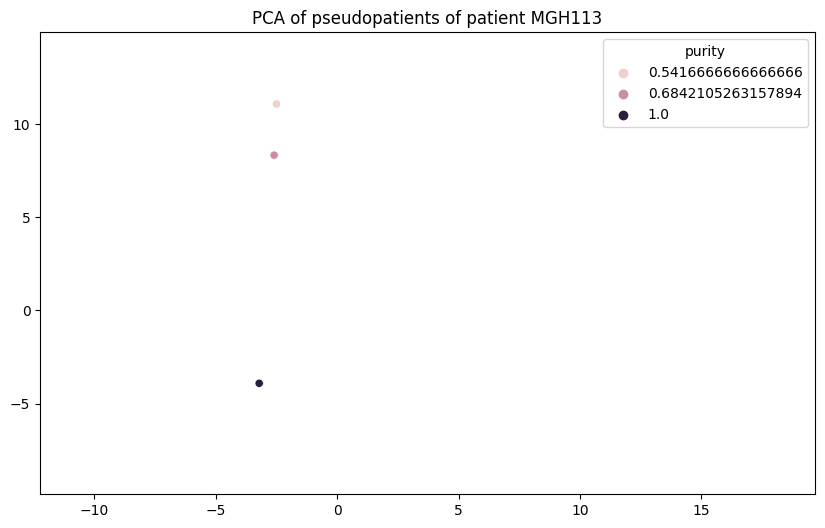

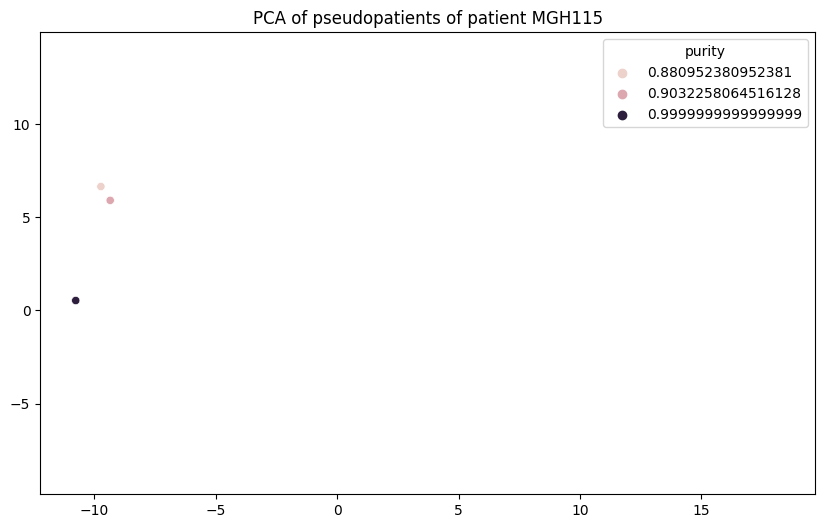

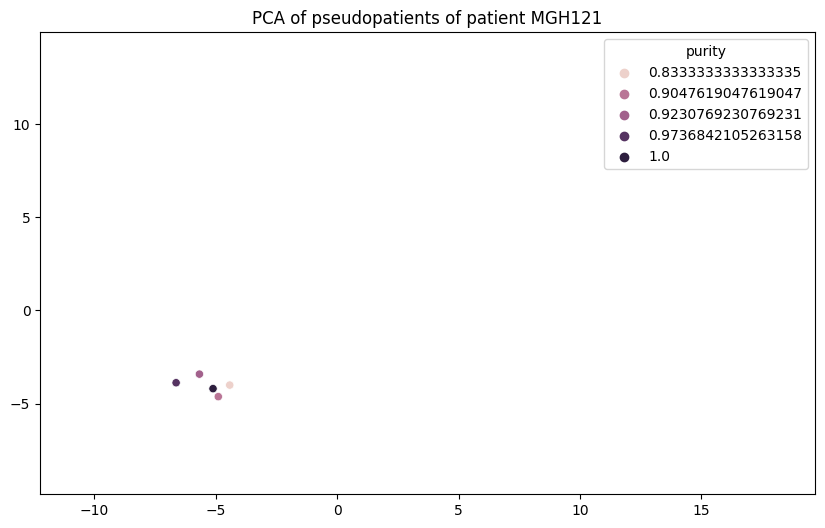

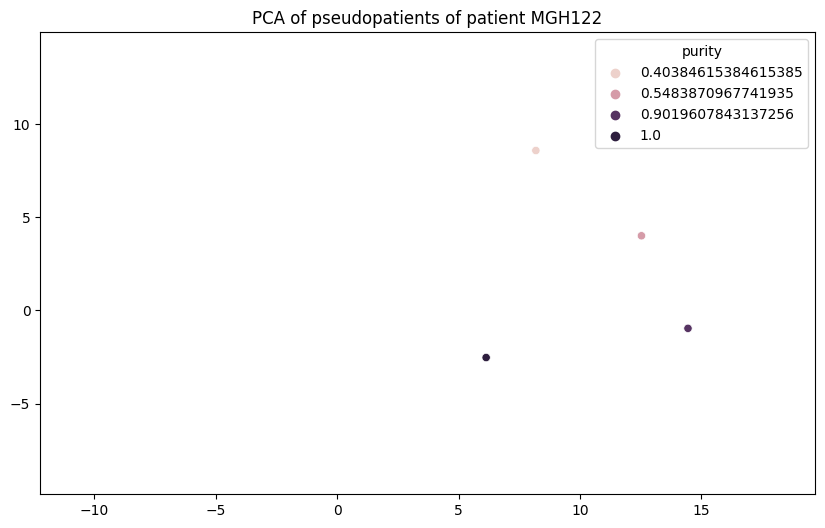

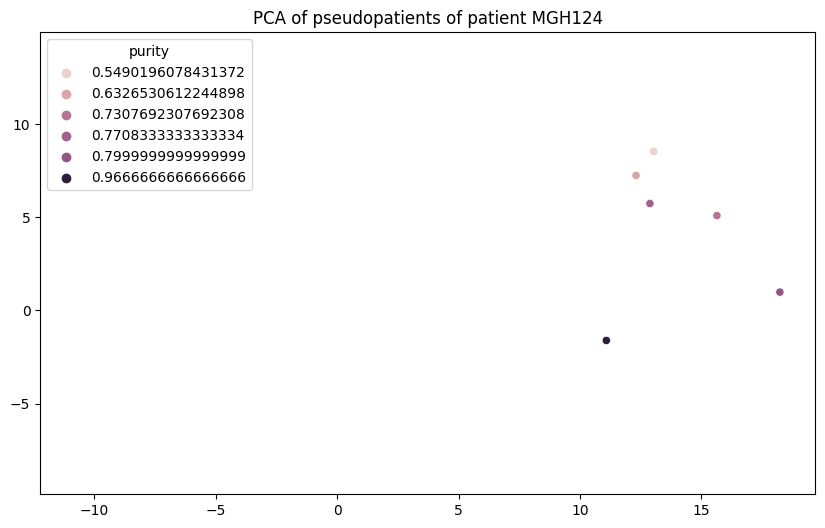

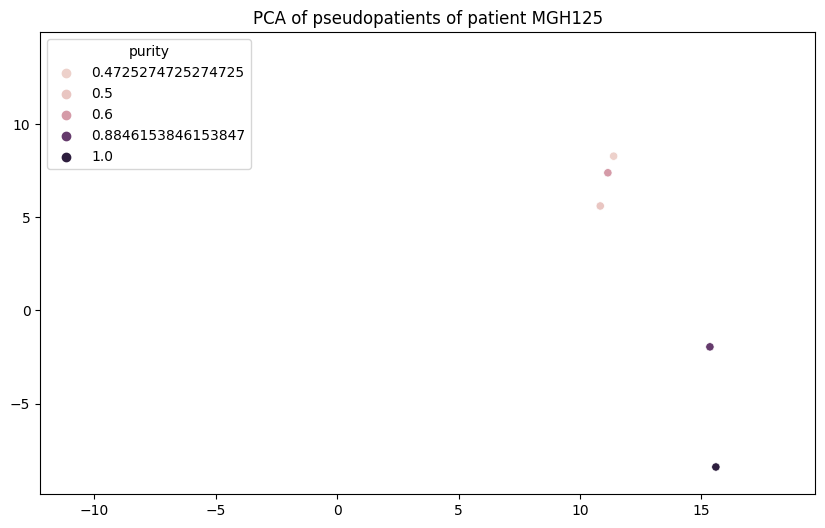

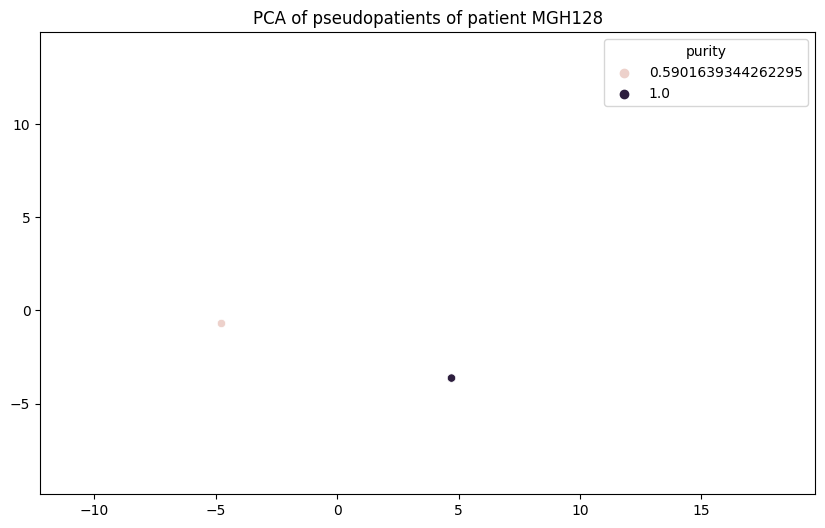

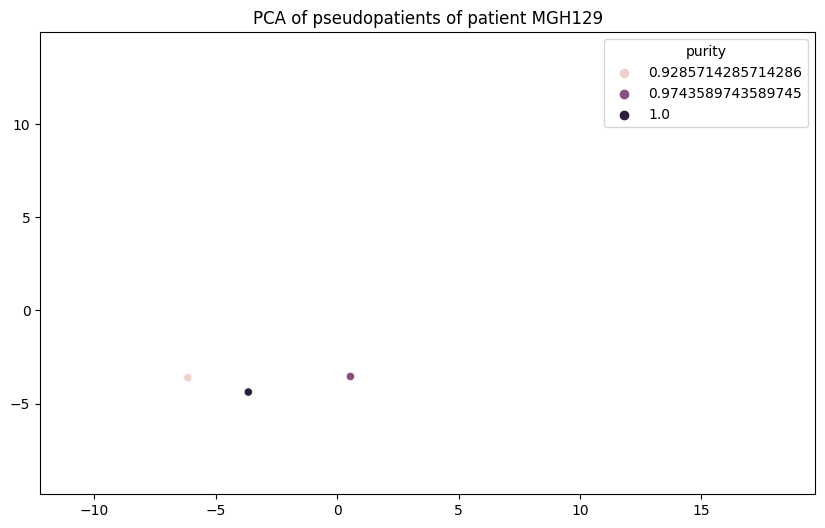

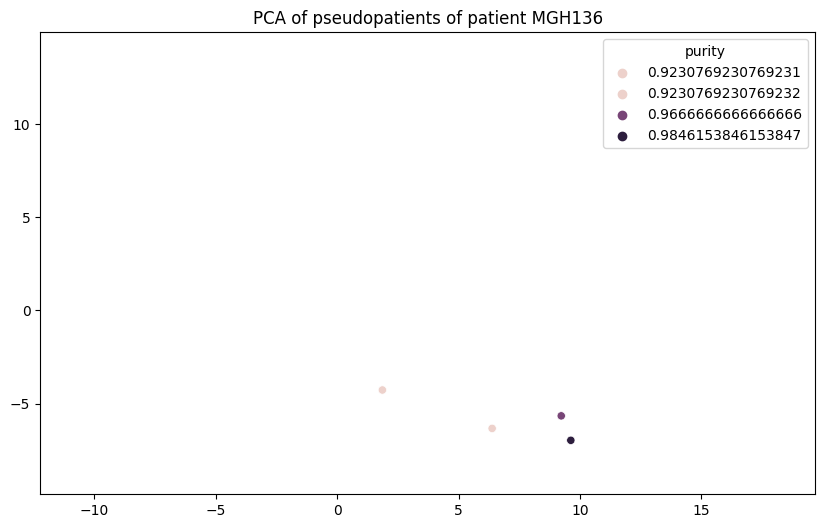

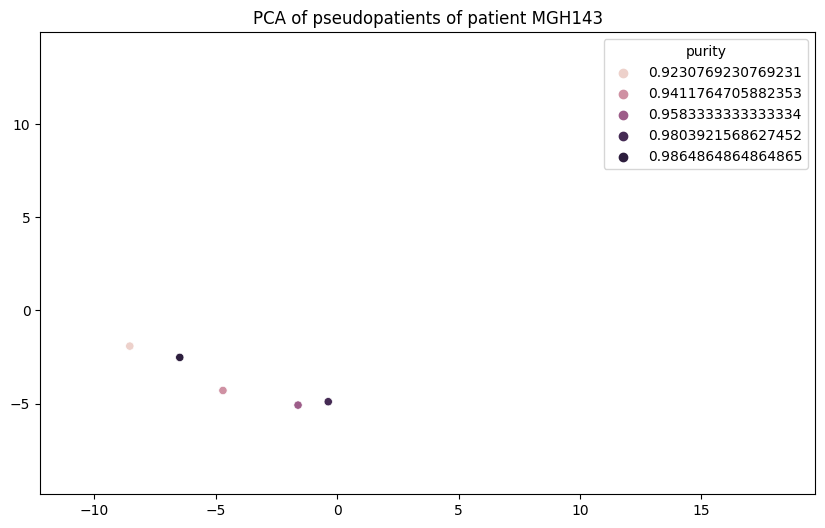

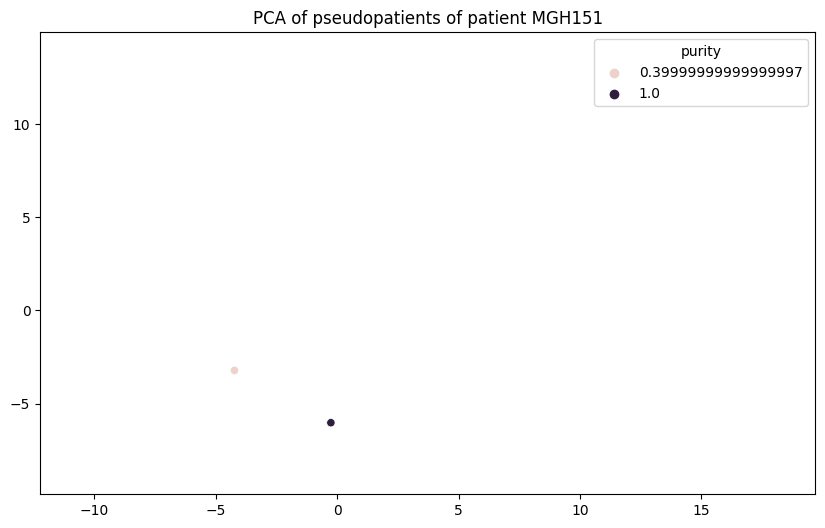

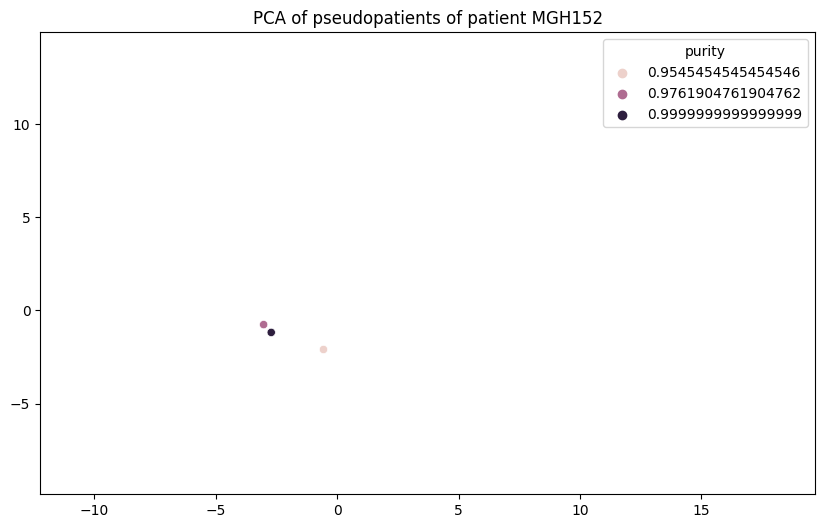

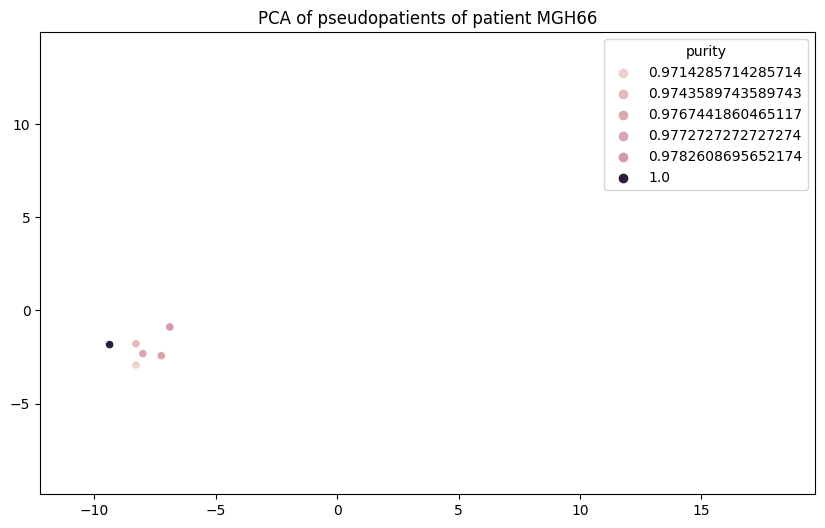

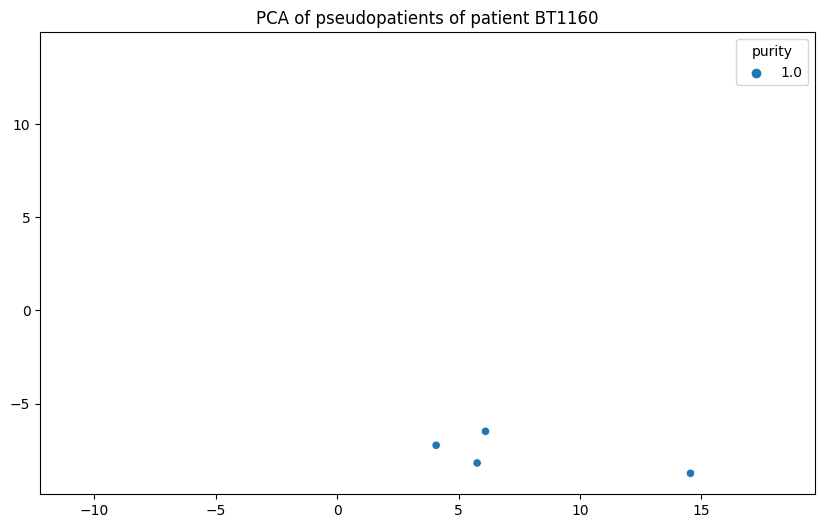

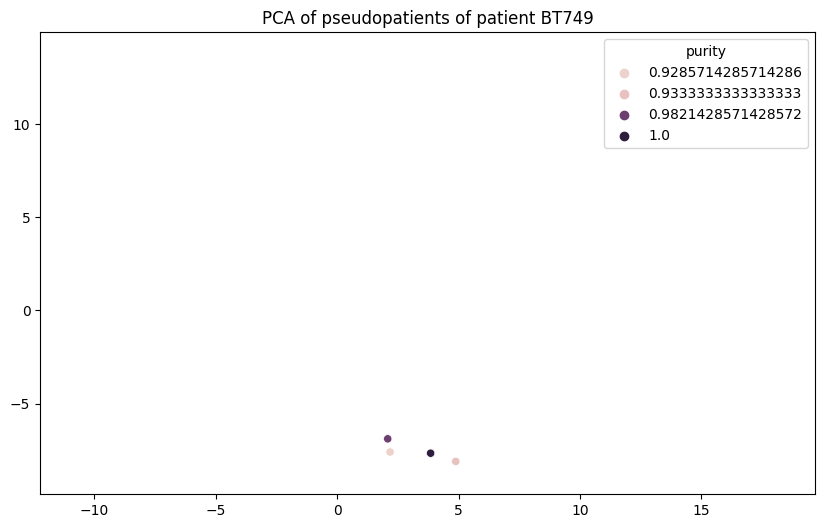

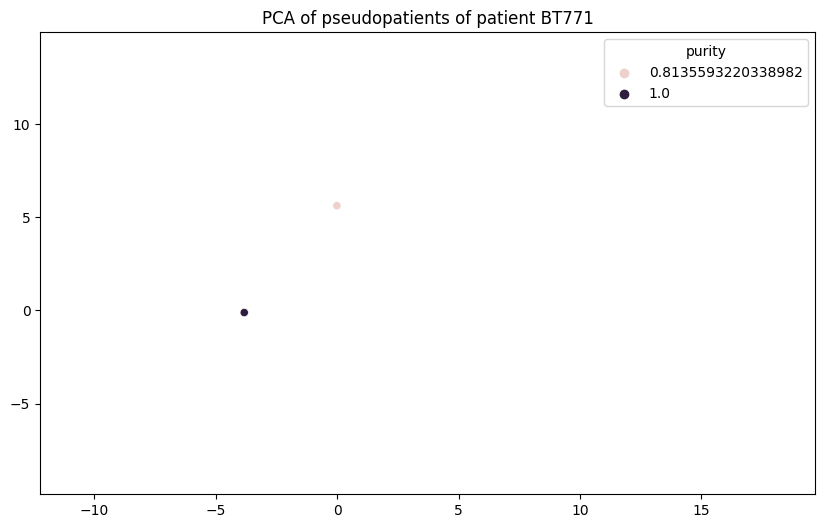

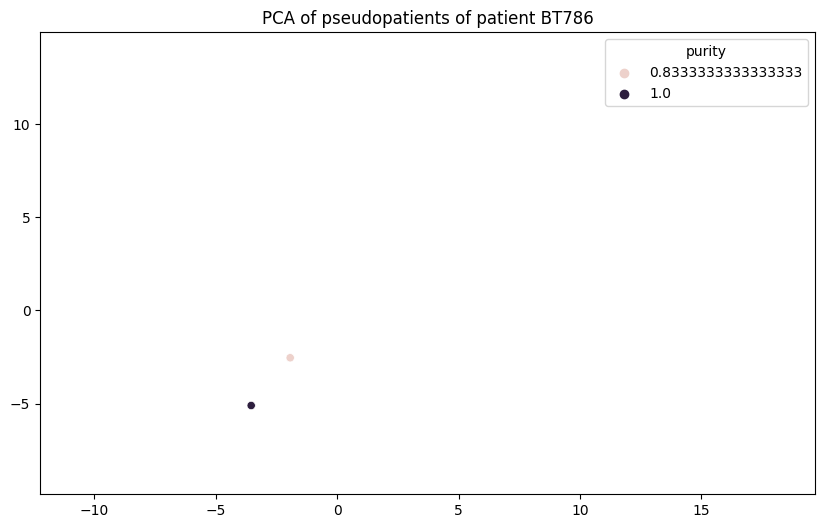

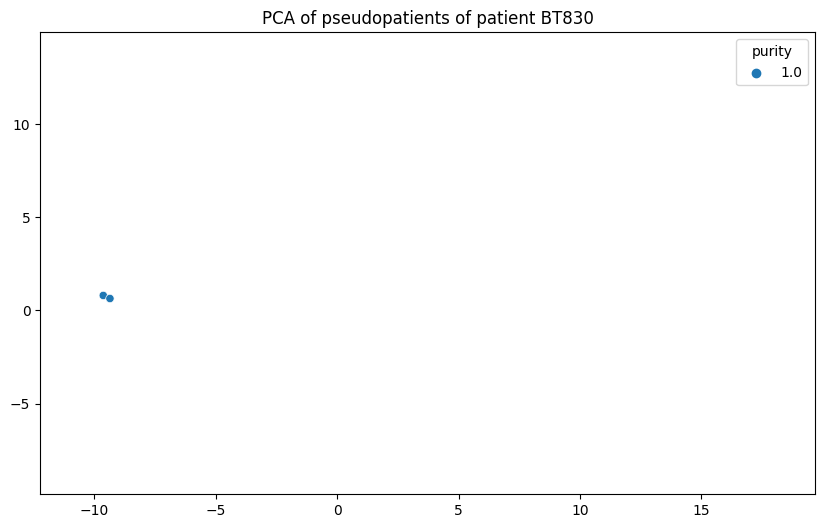

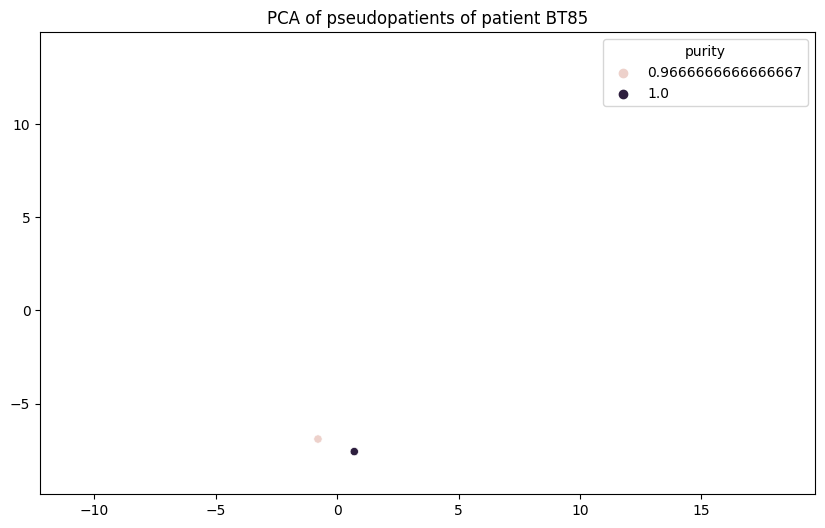

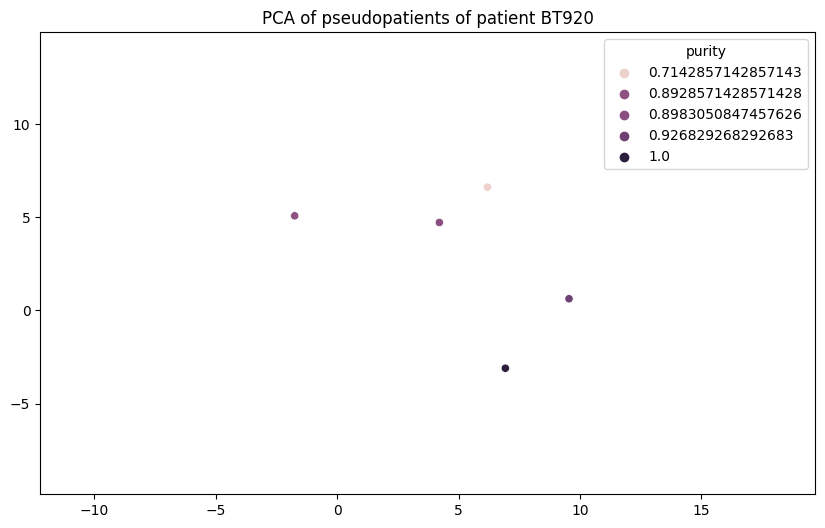

In [30]:
for patient in gexp_orig.index:
    z = pca.transform(gexp.loc[patient].apply(lambda x: np.log2(x+1)))
    pc1, pc2 = zip(*z)
    plt.figure(figsize=(10,6))
    plt.xlim(xlim)
    plt.ylim(ylim)
    sns.scatterplot(x=pc1,y=pc2,hue=true_prop.loc[patient]["purity"])
    plt.title(f"PCA of pseudopatients of patient {patient}")

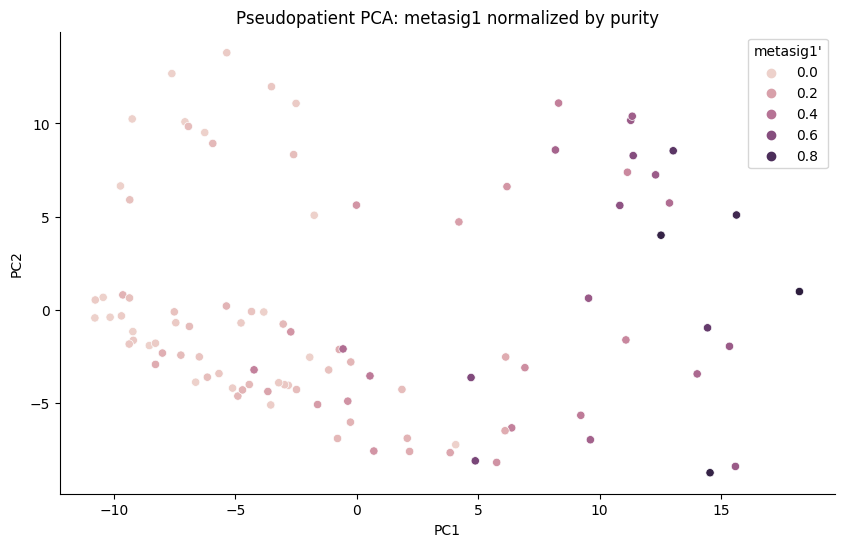

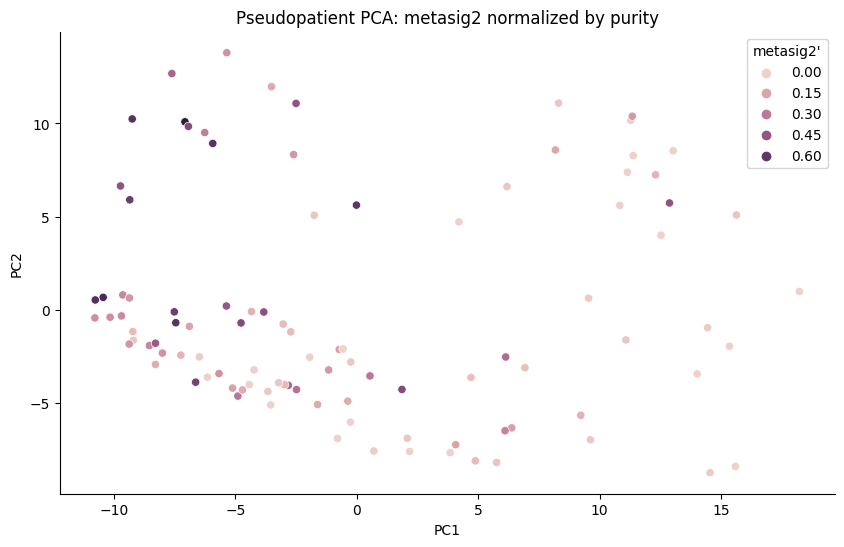

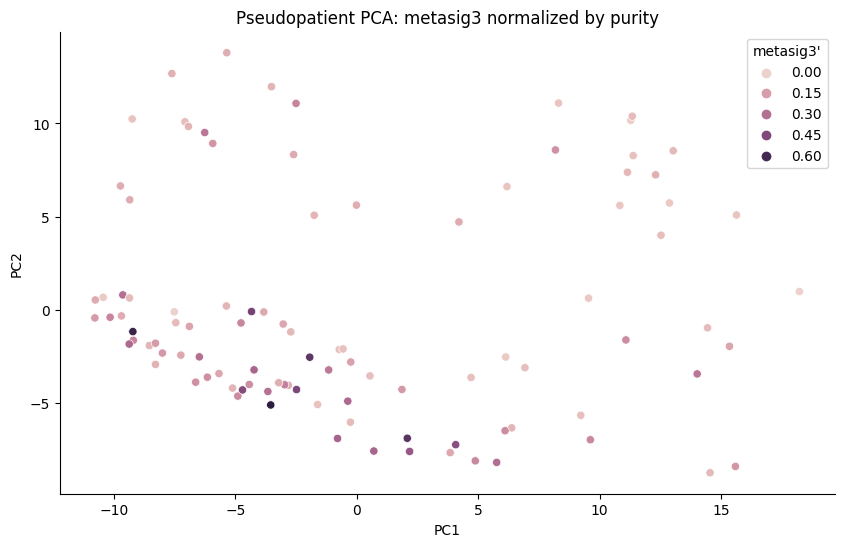

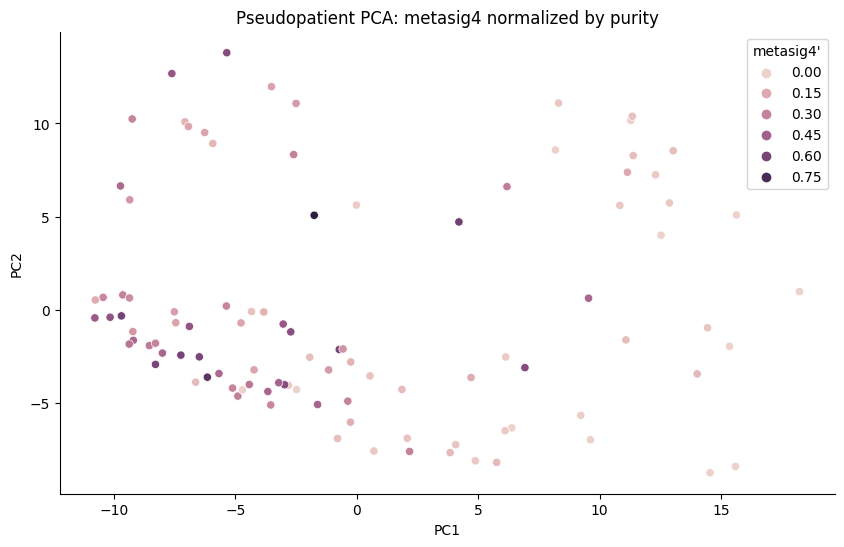

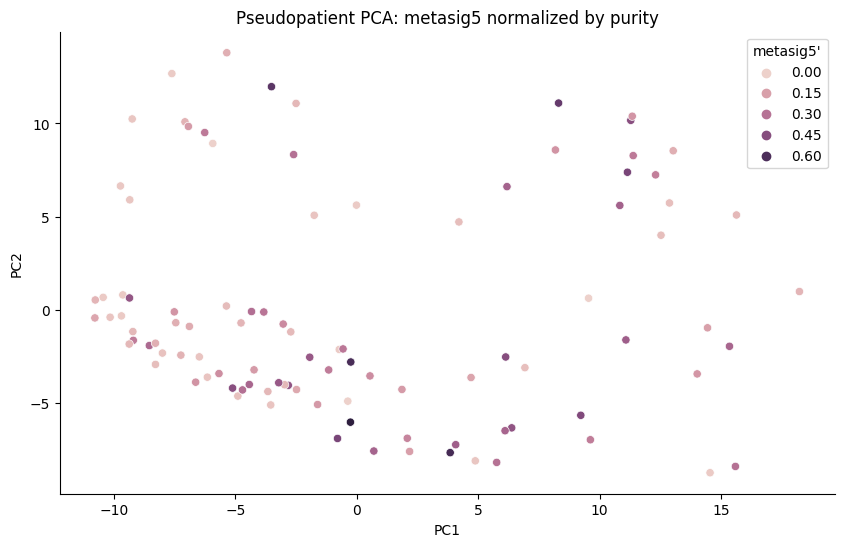

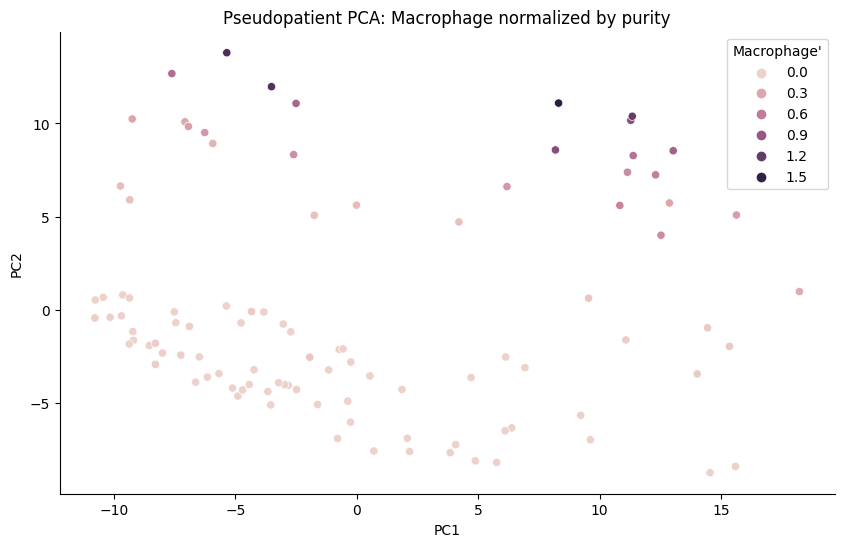

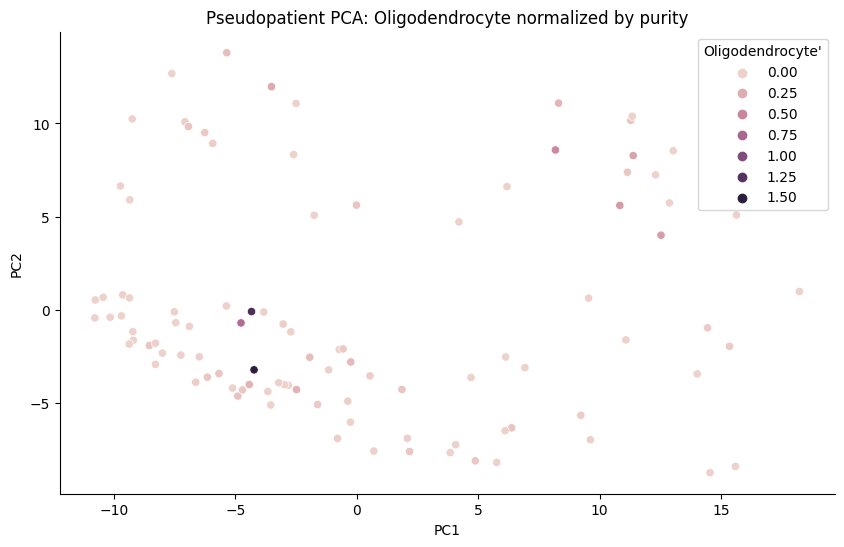

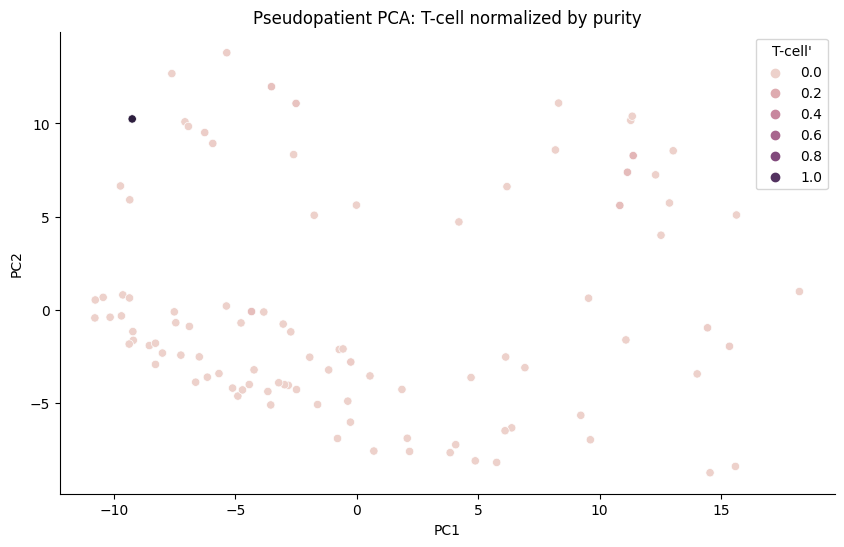

In [31]:
z = pca.transform(gexp.apply(lambda x: np.log2(x+1)))
pc1, pc2 = zip(*z)
for ct in malignant_states+tme_states:
    plt.figure(figsize=(10,6))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    true_prop[f"{ct}'"] = true_prop[ct]/true_prop["purity"]
    sns.scatterplot(x=pc1,y=pc2,hue=true_prop[f"{ct}'"])
    plt.title(f"Pseudopatient PCA: {ct} normalized by purity")
    plt.show()

<AxesSubplot: xlabel="('MGH100', '0')", ylabel='Density'>

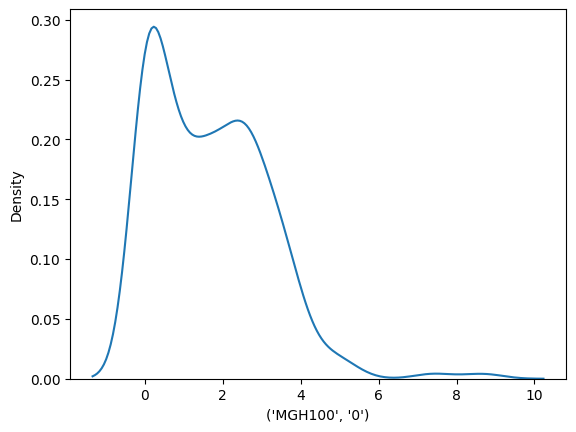

In [32]:
sns.kdeplot(gexp.iloc[0].apply(lambda x: np.log2(x+1)))